In [58]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
plt.style.use("ggplot")

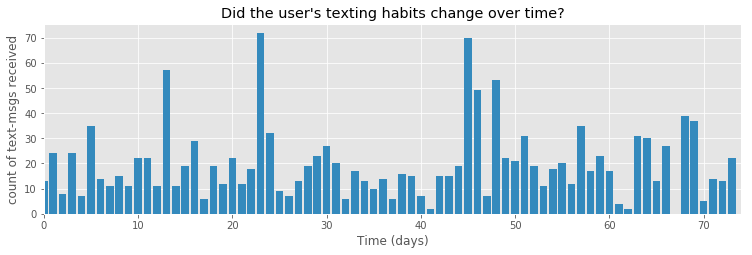

In [59]:
figsize(12.5, 3.5)
count_data = np.loadtxt("../Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/Chapter1_Introduction/data/txtdata.csv")
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data);

## 1 (a)

In [60]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
    alpha_1 = 1.0/count_data[:40].mean()  # Recall count_data is the
                                         # variable that holds our txt counts
    alpha_2 = 1.0/count_data[40:n_count_data+1].mean()
    
    lambda_1 = pm.Exponential("lambda_1", alpha_1)
    lambda_2 = pm.Exponential("lambda_2", alpha_2)
    
    #tau = pm.Constant('tau', c=40)
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data - 1)

In [61]:
with model:
    idx = np.arange(n_count_data) # Index
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)

In [62]:
with model:
    observation = pm.Poisson("obs", lambda_, observed=count_data)

In [63]:
### Mysterious code to be explained in Chapter 3.
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 4 chains: 100%|██████████| 60000/60000 [00:08<00:00, 6794.71draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [64]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

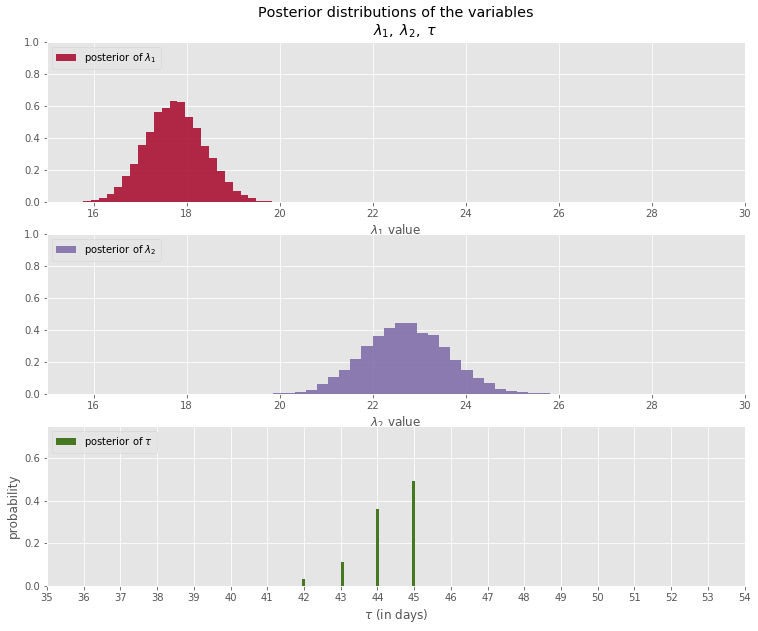

In [65]:
figsize(12.5, 10)
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", density=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");

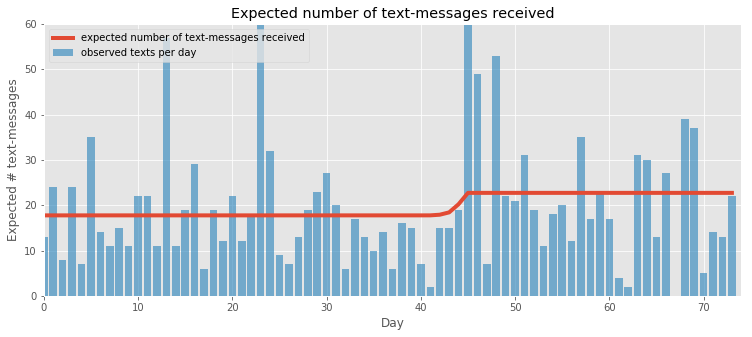

In [66]:
figsize(12.5, 5)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "message count".
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of text-messages received")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left");

**My Comment:** 

The choice of specific number of piror $\tau$ does not have significant impact on posterior $\tau$. As the above graph shows, there is no change comparing with the book.

## 1 (b)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 4 chains: 100%|██████████| 60000/60000 [00:09<00:00, 6555.03draws/s]
The number of effective samples is smaller than 25% for some parameters.


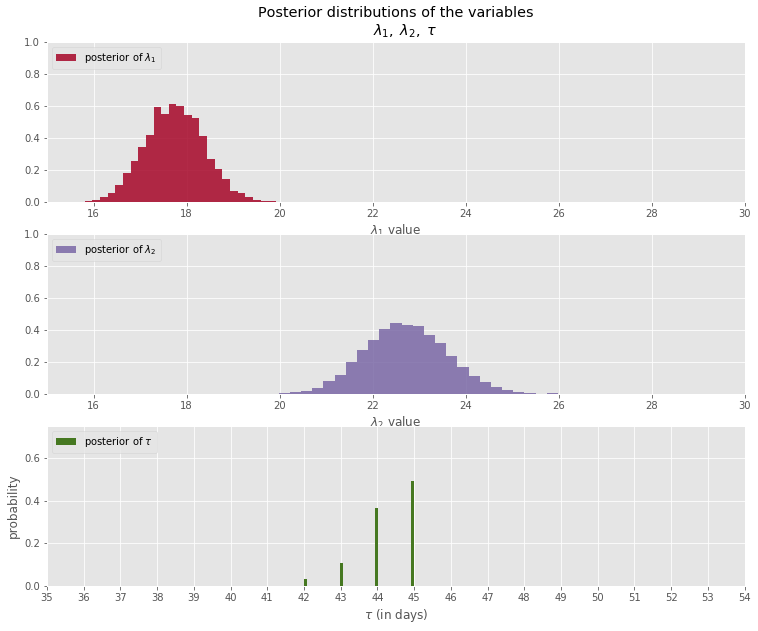

In [67]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
    alpha_1 = 1.0/count_data[:25].mean()  # Recall count_data is the
                                         # variable that holds our txt counts
    alpha_2 = 1.0/count_data[25:n_count_data].mean()
    
    lambda_1 = pm.Exponential("lambda_1", alpha_1)
    lambda_2 = pm.Exponential("lambda_2", alpha_2)
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data - 1)
    
with model:
    idx = np.arange(n_count_data) # Index
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)

with model:
    observation = pm.Poisson("obs", lambda_, observed=count_data)

### Mysterious code to be explained in Chapter 3.
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step)

lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

figsize(12.5, 10)
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", density=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");

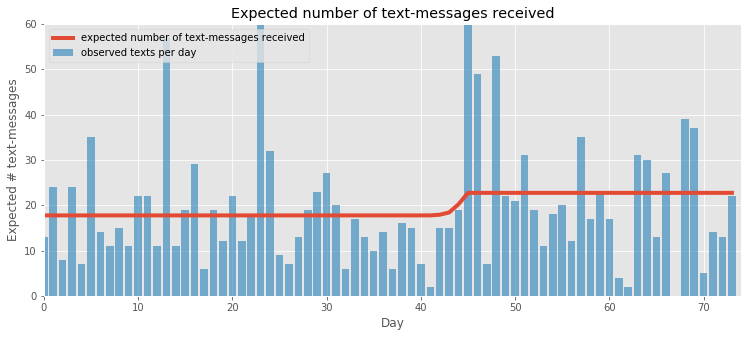

In [68]:
figsize(12.5, 5)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "message count".
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of text-messages received")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left");

**My Comment:** 

The choice of specific number of piror $\tau$ does not have significant impact on posterior $\tau$. As the above graph shows, there is no change comparing with the book.

## 1(c)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 4 chains: 100%|██████████| 60000/60000 [00:08<00:00, 6820.58draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


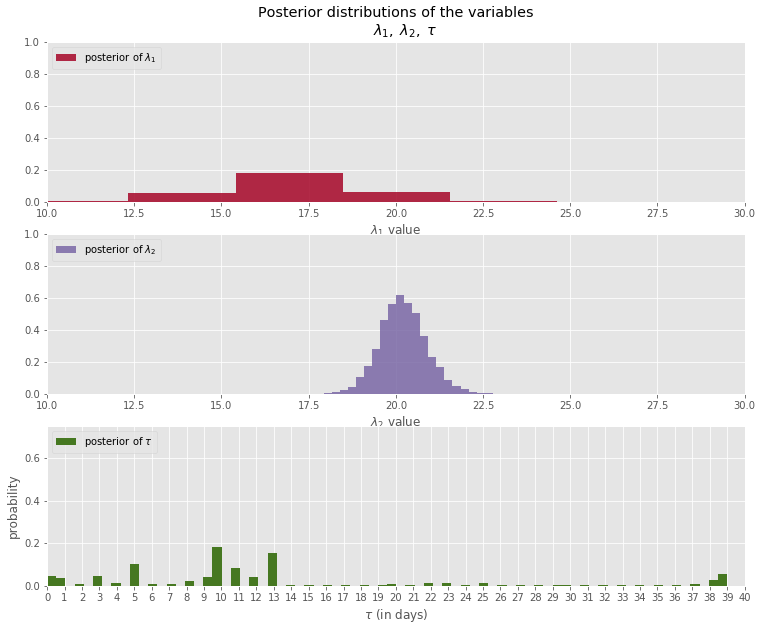

In [69]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
    alpha = 1.0/count_data.mean()  # Recall count_data is the
                                         # variable that holds our txt counts
    
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=39)
    
with model:
    idx = np.arange(n_count_data) # Index
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)

with model:
    observation = pm.Poisson("obs", lambda_, observed=count_data)

### Mysterious code to be explained in Chapter 3.
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step)

lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

figsize(12.5, 10)
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([10, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", density=True)
plt.legend(loc="upper left")
plt.xlim([10, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([0, 40])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");

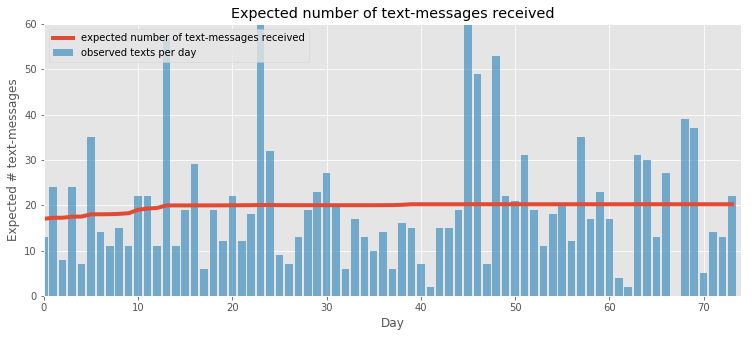

In [70]:
figsize(12.5, 5)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "message count".
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of text-messages received")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left");

**My Comment:** 

The choice of distribution of piror $\tau$ has significant impact on posterior belief in what $\tau$ is. As the above graph shows, the red line changed a lot from the book, indicating the new changepoint occurs somewhere near day 13.

## 2 The Monty Hall Problem:   
Suppose you're given the choice of three doors: behind one door is a car; behind the others, goats. You pick a door, say No. 1, and the host, who knows what's behind the doors, opens another door, say No. 3, which has a goat. He then says to you, "Do you want to switch to door No. 2?" The question is whether or not it to your advantage to
switch your choice.

(a) Simulate an experiment that tests this question and calculate your "best guess" of what
your probability of winning is if you switch doors. Note that whether or not you win is
a random variable, so histograms are helpful here. Is this surprising?

In [71]:
def prob_switch_win(n):
    succeed = 0
    fail = 0
    for i in range(n):
        car = np.random.randint(1,4, 1)
        myChoice = np.random.randint(1,4, 1)
        hostOpen = np.random.choice(list(set([1,2,3]) - set(car)-set(myChoice)), 1)
        switch = np.random.choice(list(set([1,2,3])-set(hostOpen)-set(myChoice)),1)  # always switch
        if car == switch:
            succeed +=1
        if car != switch:
            fail +=1
        prob = succeed/n
    return prob

In [72]:
def simulate_distn(trial_num, n):
    prob_dist = []
    for i in range(trial_num):
        prob_dist.append(prob_switch_win(n))
    return prob_dist

In [73]:
# experiment 5000 times, each experiment we create 200 samples
distn = simulate_distn(5000,200)

Text(0.5,0,'probability of winning after switching')

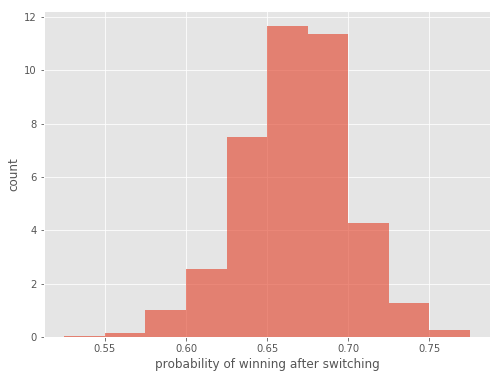

In [77]:
figsize(8, 6)
plt.hist(distn, density=True, bins=10, alpha=0.65)
plt.ylabel('count')
plt.xlabel('probability of winning after switching')

In [78]:
print('The average probability of winning after switching is', np.mean(distn))

The average probability of winning after switching is 0.6667719999999999


## 2(b) 
Analytically calculate the probability of winning if you switch doors.

Let $P(1)$ denote probability of car behind door 1, $P(2)$ car behind door 2, $P(3)$ car behind door 3 and we know $P(1)=P(2)=P(3)=1/3$.  
Assume door 1 is picked , the probability of winning after swtiching door can be computed though: 
$P(2|Host\ opens\ 3) = \frac{P(Host\ opens\ 3|2)\times P(2)}{P(Host\ opens\ 3)}$

Since car could be behind any of the three doors, we can compute the following conditional probability:  
$P(Host\ opens\ 3|1) = 1/2$  
$P(Host\ opens\ 3|2) = 1$  
$P(Host\ opens\ 3|3) = 0$

So, the probability host opens Door3 is (according to law of total probability): 

$
\begin{aligned}
P(Host\ opens\ 3) &= P(1)P(Host\ opens\ 3|car\ behind\ 1) + 
                     P(2)P(Host\ opens\ 3|car\ behind\ 2) + 
                     P(3)P(Host\ opens\ 3|car\ behind\ 3) \\
&= 1/3*1/2 + 1/3*1 + 1/3*0 \\
&= 1/2
\end{aligned}
$

Therefore the probability of winning if switch door is:  
$
\begin{align*}
P(2|Host\ opens\ 3) &= \frac{P(Host\ opens\ 3|2)\times P(2)}{P(Host\ opens\ 3)} \\
&= \frac{1\times 1/3}{1/2} \\
&= 2/3
\end{align*}
$

## 3 The Birthday Problem: 
Our class has around 40 students. Assume that all birthdays are equally likely and you may assume no one in the class was born on February 29th. You are interested in calculating the probability that there are at least two people with the same birthday.  

**(a) Simulate an experiment that enables you can estimate the probability that there are at
least two people with the same birthday in a class of 40. What probability do you obtain?**

365 days/ unique birthdays

In [79]:
def same_birthday_distn(num_exp, n, class_size):
    distn = []
    for i in range(num_exp):
        num = 0
        for j in range(n):
            sample = np.random.randint(1,366, class_size)
            unique, counts = np.unique(sample, return_counts=True)
            if [count for count in counts if count>1]:
                num += 1
        distn.append(num/n)
    return distn

In [80]:
distn = same_birthday_distn(1000, 500, 40)

Text(0.5,0,'probability of at least two same birthday')

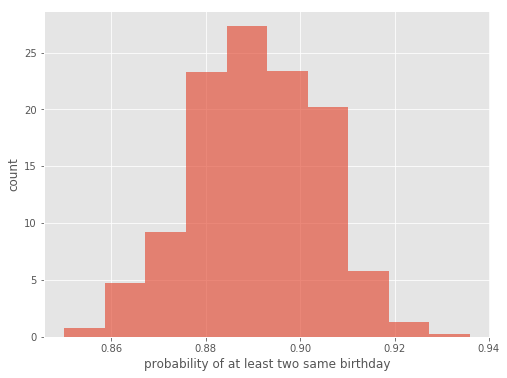

In [81]:
figsize(8, 6)
plt.hist(distn, density=True, bins=10, alpha=0.65)
plt.ylabel('count')
plt.xlabel('probability of at least two same birthday')

In [82]:
print('Probability of at least two people with same birthday in a class of 40 on average is:', np.mean(distn))

Probability of at least two people with same birthday in a class of 40 on average is: 0.890712


**(b) Generalize the above simulation for a class of size n, for any n > 1. By estimating the probabilities for a range of n, what is the minimum size of class required for there to be a probability of 0.50 or higher of having two students with the same birthday?**

first person (we don't care which day he/she is born) $1=\frac{365}{365}$  
if n=2, probability of them having same birthday: $1 - \frac{364}{365}$

if n=3, probability of them having same birthday: $1- \frac{364}{365}\times \frac{363}{365}$  
...  
for n , probability of two students with same birthday: $1 - \frac{\frac{364!}{(365-n)!}}{365^{(n-1)}}$

In [83]:
prob = 0
n = 2

while prob < 0.5:
    prob = np.mean(same_birthday_distn(1000, 100, n))
    n += 1

In [84]:
print('Minimum size of class required for prob of 0.5 or higher of having two students with same birthday is', n-1)

Minimum size of class required for prob of 0.5 or higher of having two students with same birthday is 23


## 4
The Golden Gate Transit bus travels between the San Anselmo and San Francisco, which are 20
miles apart. If the bus has a breakdown, the distance from the breakdown to San Anselmo has
a uniform distribution over (0, 20). Currently, there is a bus service station in San Anselmo,
San Francisco and in the center of the route between the two cities. It is suggested that it
would be more efficient to have the three stations located 5, 10, and 15 miles, respectively,
from San Anselmo. Conduct a simulation study that compares these two competing strategies
and discuss which option you think is advisable.

In [85]:
def old_strategy_dist(sim_num, n):
    dist_distn=[]
    for i in range(sim_num):
        dist = 0
        for j in range(n):
            breakdown = np.random.uniform(0,20)
            dist += min(abs(breakdown),abs(breakdown-10), abs(breakdown-20))
        dist_distn.append(dist/n)
    return dist_distn

In [86]:
old_strategy = old_strategy_dist(1000, 1000)

Text(0.5,0,'average distance per breakdown')

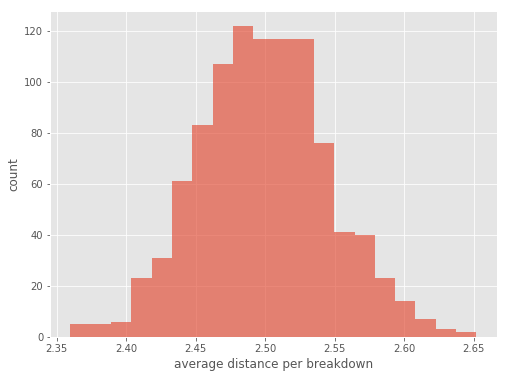

In [87]:
figsize(8, 6)
plt.hist(old_strategy, bins=20, alpha=0.65)
plt.ylabel('count')
plt.xlabel('average distance per breakdown')

In [88]:
def new_strategy_dist(sim_num, n):
    dist_distn=[]
    for i in range(sim_num):
        dist = 0
        for j in range(n):
            breakdown = np.random.uniform(0,20)
            dist += min(abs(breakdown-5),abs(breakdown-10), abs(breakdown-15))
        dist_distn.append(dist/n)
    return dist_distn

In [89]:
new_strategy = new_strategy_dist(1000, 1000)

Text(0.5,0,'average distance per breakdown')

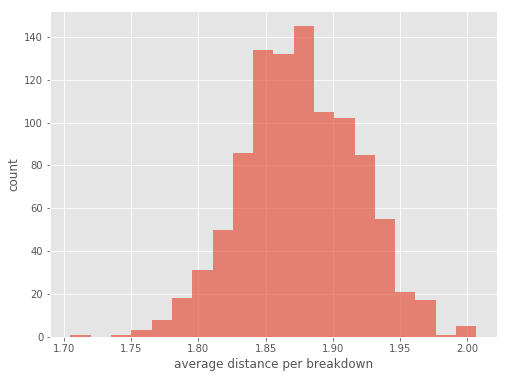

In [90]:
figsize(8, 6)
plt.hist(new_strategy, bins=20, alpha=0.65)
plt.ylabel('count')
plt.xlabel('average distance per breakdown')

In [91]:
print('Old strategy: average travel distance per breakdown is', round(np.mean(old_strategy),4))
print('New strategy: average travel distance per breakdown is', round(np.mean(new_strategy),4))

Old strategy: average travel distance per breakdown is 2.499
New strategy: average travel distance per breakdown is 1.8758


From the simulations above, we can see that the average distance traveled for a breakdown with the old strategy is 2.503, whereas the average distance traveled for a breakdown with the new strategy is 1.8744. So the new strategy is more efficient.  